# Everything-you-can-do-with-a-time-series
原项目地址：[https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series/notebook](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series/notebook)



# content



# [日期和时间简介](#content)


## [导入时间序列数据](#content)

### [如何导入数据](#content)
所需要的数据在data目录下。使用parse_dates参数将所需的时间序列列导入为datetime列，并使用index_col参数将其选择为数据帧的索引。

### [使用的数据](#content)
- Google Stocks Data
- Humidity in different world cities
- Microsoft Stocks Data
- Pressure in different world cities

### [导入资源](#content)

In [83]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
# import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

In [2]:
google = pd.read_csv('./data/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [3]:
humidity = pd.read_csv('./data/humidity.csv', index_col='datetime', parse_dates=['datetime'])
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0


## [数据清洗与准备](#content)

In [4]:
google.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [5]:
humidity.isnull().sum()

Vancouver            1826
Portland              449
San Francisco         942
Seattle               289
Los Angeles           152
San Diego             344
Las Vegas             842
Phoenix              1308
Albuquerque           710
Denver               1808
San Antonio           564
Dallas                319
Houston               121
Kansas City           512
Minneapolis           510
Saint Louis          1289
Chicago              1109
Nashville             567
Indianapolis          695
Atlanta               422
Detroit               862
Jacksonville          209
Charlotte             589
Miami                1087
Pittsburgh            522
Toronto               728
Philadelphia          624
New York             1624
Montreal             1696
Boston                449
Beersheba             859
Tel Aviv District    1113
Eilat                 970
Haifa                 818
Nahariyya             817
Jerusalem             906
dtype: int64

In [6]:
humidity.shape

(45253, 36)

Google股票数据没有缺失值，但是湿度数据确实有缺失值。 使用带有ffill参数的fillna()对其进行清理，该方法传播最后的有效观察值以填补空白。

In [7]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 17:00:00,78.0,79.0,84.0,79.0,88.0,80.0,21.0,24.0,49.0,63.0,...,69.0,57.0,80.0,68.0,54.0,62.0,23.0,51.0,51.0,50.0


In [8]:
humidity.isnull().sum()

Vancouver            0
Portland             0
San Francisco        0
Seattle              0
Los Angeles          0
San Diego            0
Las Vegas            0
Phoenix              0
Albuquerque          0
Denver               0
San Antonio          0
Dallas               0
Houston              0
Kansas City          0
Minneapolis          0
Saint Louis          0
Chicago              0
Nashville            0
Indianapolis         0
Atlanta              0
Detroit              0
Jacksonville         0
Charlotte            0
Miami                0
Pittsburgh           0
Toronto              0
Philadelphia         0
New York             0
Montreal             0
Boston               0
Beersheba            0
Tel Aviv District    0
Eilat                0
Haifa                0
Nahariyya            0
Jerusalem            0
dtype: int64

## [数据可视化](#content)

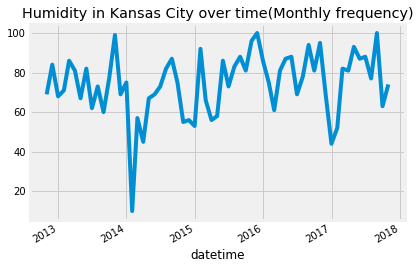

In [9]:
humidity["Kansas City"].asfreq('M').plot() 
# asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
# asfreq方法用于将时间序列转换为指定频率。这是每月的频率。按照月份对数据做聚合
plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.show()

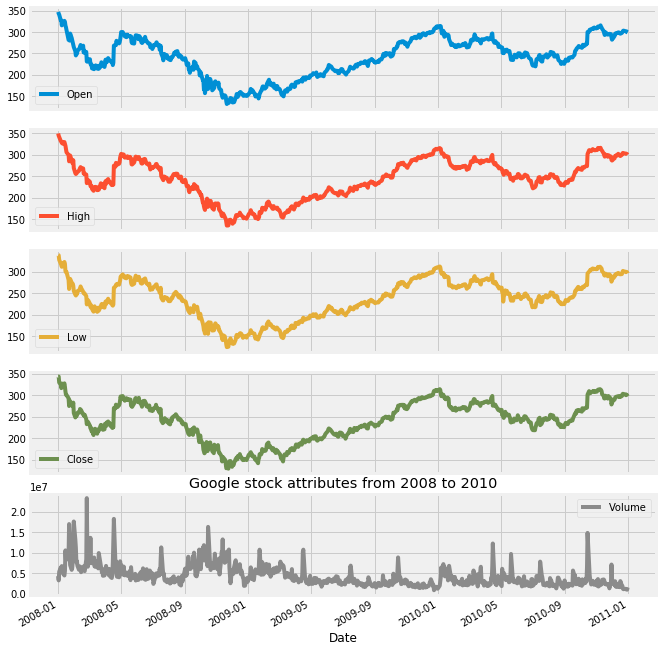

In [10]:
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
plt.show()

## [时间戳和时间段](#content)
时间戳用于表示时间点。 时间段代表时间间隔。 时间间隔可用于检查给定期间内是否有特定事件。 它们也可以转换为彼此的形式。

In [11]:
timestamp = pd.Timestamp(2017,1,1,12)
print(timestamp)

2017-01-01 12:00:00


In [12]:
period = pd.Period('2017-01-01')
print(period)

2017-01-01


In [13]:
period

Period('2017-01-01', 'D')

In [14]:
# 检查时间戳是否在指定的区间
period.start_time < timestamp < period.end_time

True

In [15]:
new_period = timestamp.to_period(freq = 'H')
print(new_period)

2017-01-01 12:00


In [16]:
new_timestamp = period.to_timestamp(freq = 'H', how = 'start')
print(new_timestamp)

2017-01-01 00:00:00


# 时间间隔
date_range是一种返回固定频率datetimeindex的方法。 当创建自己的时间序列属性以用于预先存在的数据或围绕您创建的时间序列属性排列整个数据时，此功能非常有用。

In [17]:
# 以日为间隔创建datetimeindex
dr1 = pd.date_range(start='1/1/18', end = '1/9/18')
print(dr1)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')


In [18]:
# 以月为间隔创建datetimeindex
dr2 = pd.date_range(start = '1/1/18', end = '1/1/19', freq = 'M')
print(dr2)

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')


In [20]:
# 不指定终止时间而用period代替
dr3 = pd.date_range(end = '1/4/2014', periods = 8)
print(dr3)

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')


In [21]:
# 在指定终止时间的情况下指定period
dr4 = pd.date_range(start = '2013-04-24', end = '2014-11-27', periods = 3)
print(dr4)

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)


### 使用to_datetime函数
pandas.to_datetime()用于将参数转换为日期时间。 在这里，DataFrame将被转换为日期时间序列。

In [23]:
df = pd.DataFrame({'year' : [2015,2016], 'month':[2,3], 'day':[4,5]})
print(df)

   year  month  day
0  2015      2    4
1  2016      3    5


In [26]:
df = pd.to_datetime(df)
print(df)

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]


In [27]:
df = pd.to_datetime('01-01-2017')
print(df)

2017-01-01 00:00:00


### [偏移和滞后](#content)
我们可以使用可选的时间频率将索引按所需的周期数移动。 将时间序列与其自身的过去进行比较时，这很有用

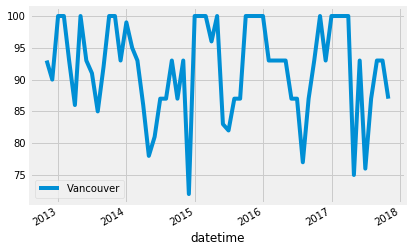

In [28]:
humidity["Vancouver"].asfreq('M').plot(legend=True)

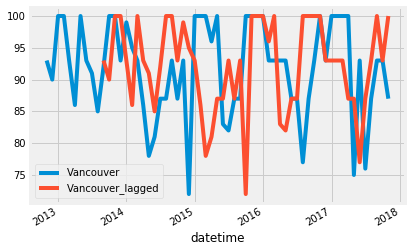

In [31]:
humidity["Vancouver"].asfreq('M').plot(legend=True)
shifted = humidity["Vancouver"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

### [重采样](#content)
**上采样**-时间序列从低频到高频（从每月到每天）重新采样。 它涉及填充或内插丢失的数据。

**下采样**-时间序列从高频重新采样到低频（每周一次到每月一次）。 它涉及现有数据的汇总。

In [48]:
pressure = pd.read_csv('./data/pressure.csv', index_col='datetime', parse_dates=['datetime'])
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,1031.0,NaN,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,NaN,1021.0,1017.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,1030.0,NaN,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,NaN,1023.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,1030.0,NaN,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,NaN,1024.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,1029.0,NaN,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,NaN,1026.0,1022.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,1029.0,NaN,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,NaN,1027.0,1023.0,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pressure.isnull().sum()

Vancouver            4234
Portland                4
San Francisco         815
Seattle                13
Los Angeles           252
San Diego             175
Las Vegas              88
Phoenix               594
Albuquerque           456
Denver                543
San Antonio            17
Dallas                 60
Houston                 9
Kansas City           121
Minneapolis            17
Saint Louis            68
Chicago               725
Nashville             147
Indianapolis          289
Atlanta                49
Detroit                 5
Jacksonville           15
Charlotte               3
Miami                 794
Pittsburgh             46
Toronto               175
Philadelphia            4
New York             1041
Montreal              994
Boston                  7
Beersheba             806
Tel Aviv District     930
Eilat                 792
Haifa                 798
Nahariyya             795
Jerusalem             799
dtype: int64

In [50]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method='ffill')
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,1021.0,1031.0,1013.0,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,1020.0,1021.0,1017.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 21:00:00,1021.0,1030.0,1013.0,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,1020.0,1023.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 22:00:00,1021.0,1030.0,1013.0,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,1020.0,1024.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 23:00:00,1021.0,1029.0,1013.0,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,1020.0,1026.0,1022.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-30 00:00:00,1021.0,1029.0,1013.0,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,1020.0,1027.0,1023.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0


In [51]:
pressure.isnull().sum()

Vancouver            20
Portland              0
San Francisco         0
Seattle               0
Los Angeles           0
San Diego             0
Las Vegas             0
Phoenix               0
Albuquerque           0
Denver                0
San Antonio           0
Dallas                0
Houston               0
Kansas City           0
Minneapolis           0
Saint Louis           0
Chicago               0
Nashville             0
Indianapolis          0
Atlanta               0
Detroit               0
Jacksonville          0
Charlotte             0
Miami                 0
Pittsburgh            0
Toronto               0
Philadelphia          0
New York              0
Montreal              0
Boston                0
Beersheba             0
Tel Aviv District     0
Eilat                 0
Haifa                 0
Nahariyya             0
Jerusalem             0
dtype: int64

这里仍有一些缺失值

In [52]:
pressure = pressure.fillna(method='bfill')
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 17:00:00,807.0,1024.0,1009.0,1029.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,863.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [53]:
pressure.isnull().sum()

Vancouver            0
Portland             0
San Francisco        0
Seattle              0
Los Angeles          0
San Diego            0
Las Vegas            0
Phoenix              0
Albuquerque          0
Denver               0
San Antonio          0
Dallas               0
Houston              0
Kansas City          0
Minneapolis          0
Saint Louis          0
Chicago              0
Nashville            0
Indianapolis         0
Atlanta              0
Detroit              0
Jacksonville         0
Charlotte            0
Miami                0
Pittsburgh           0
Toronto              0
Philadelphia         0
New York             0
Montreal             0
Boston               0
Beersheba            0
Tel Aviv District    0
Eilat                0
Haifa                0
Nahariyya            0
Jerusalem            0
dtype: int64

首先，我们使用ffill参数，该参数传播最后的有效观察值以填补空白。 

然后，我们使用bfill传播下一个有效观察值以填补之前的空白。

In [54]:
pressure.shape

(45252, 36)

In [55]:
# 我们使用平均值将采样频率从每小时降低到3天
pressure = pressure.resample('3D').mean()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.000000,1013.000000,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.000000,1013.000000,990.083333
2012-10-07,1013.930556,1017.444444,1016.597222,1018.736111,1013.416667,1014.222222,1012.888889,1011.861111,1005.833333,1020.458333,...,1017.958333,1016.750000,1014.152778,1016.305556,982.972222,1013.027778,1007.555556,1013.000000,1013.000000,989.833333
2012-10-10,1015.000000,1015.430556,1014.833333,1018.416667,1010.694444,1014.013889,1000.166667,1005.611111,986.000000,984.486111,...,1018.694444,1017.916667,1016.166667,1017.319444,979.763889,1006.527778,998.763889,1012.333333,1012.333333,987.888889
2012-10-13,1008.152778,1018.111111,1021.069444,1015.930556,1017.277778,1018.375000,1015.666667,1015.500000,1013.625000,1010.444444,...,1025.055556,1024.388889,1020.805556,1023.736111,984.527778,1013.027778,1007.194444,1013.000000,1013.000000,990.430556


In [56]:
pressure.shape

(629, 36)

可以看到剩下的行要少得多。 现在，我们将从3天的频率上采样到每天的频率。

In [57]:
pressure = pressure.resample('D').pad()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-02,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-03,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333
2012-10-05,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333


In [58]:
pressure.shape

(1885, 36)

行数再次增加。 如果使用正确，重新采样很酷。

# [金融与统计数据](#content)
## [百分比变化](#content)

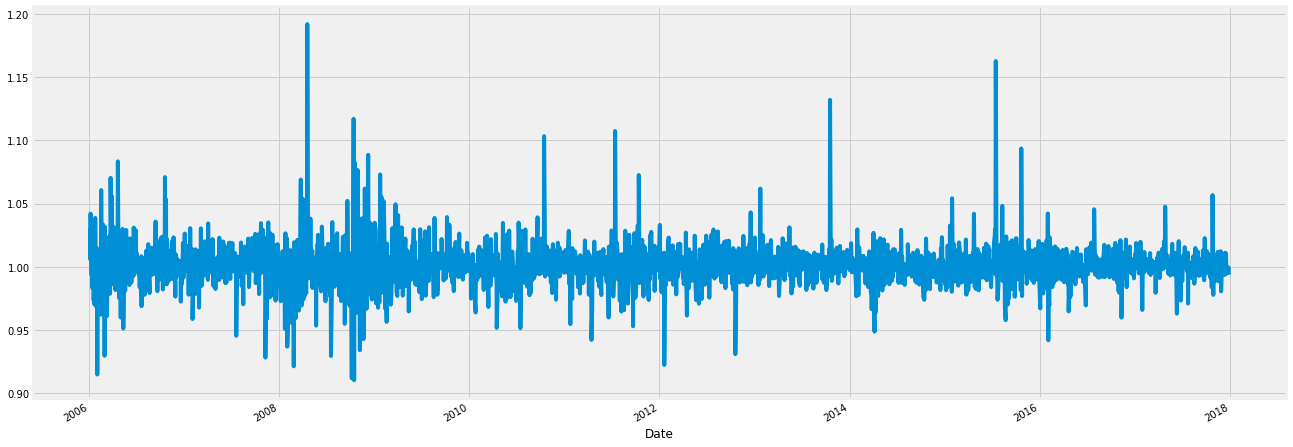

In [59]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

## [Srocks returns](#content)

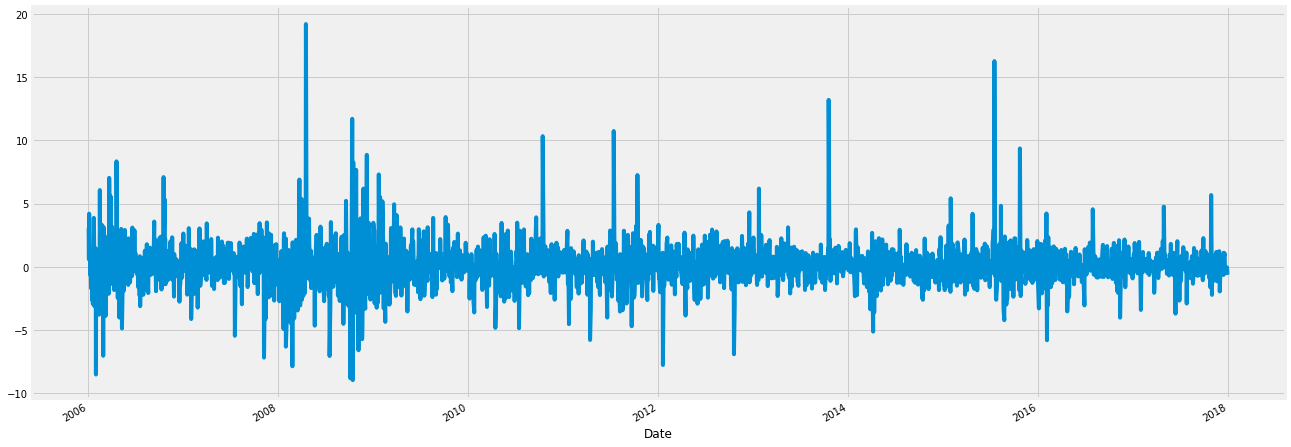

In [63]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))

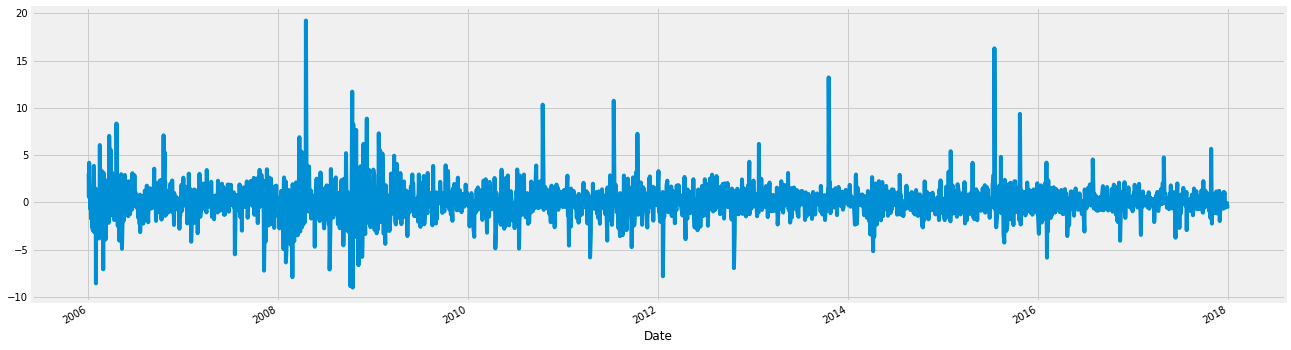

In [64]:
google.High.pct_change().mul(100).plot(figsize=(20,6))

## [连续行中的绝对变化](#content)

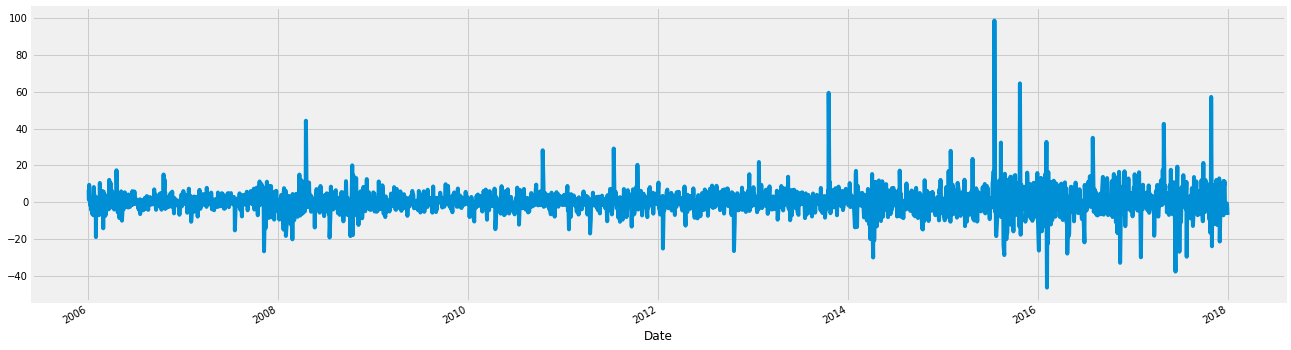

In [66]:
google.High.diff().plot(figsize=(20,6))

## [比较两个或更多个时间序列](#content)
我们将通过归一化比较两个时间序列。 这是通过将所有时间序列的每个时间序列元素除以第一个元素来实现的。 这样，两个系列都从同一点开始，可以轻松进行比较。

In [69]:
microsoft = pd.read_csv('./data/MSFT_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=['Date'])
microsoft.shape

(3019, 6)

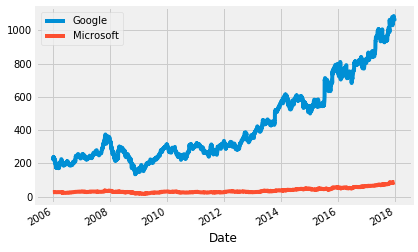

In [70]:
# 归一化之前先现实一下数据
google.High.plot()
microsoft.High.plot()
plt.legend(['Google','Microsoft'])
plt.show()

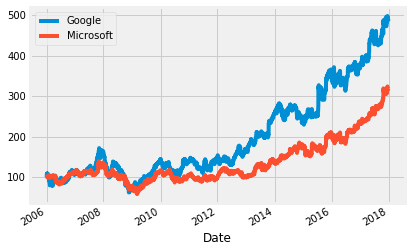

In [71]:
# 归一化并比较
# 两只股票都从100开始
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_microsoft.plot()
plt.legend(['Google','Microsoft'])
plt.show()

您可以清楚地看到Google在一段时间内的表现胜过Microsoft。

## [窗口函数](#content)

Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.

Rolling - Same size and sliding

Expanding - Contains all prior values



窗口函数用于标识子时段，计算子时段的子量。

**滚动**-相同大小和滑动

**扩展**-包含所有先前值

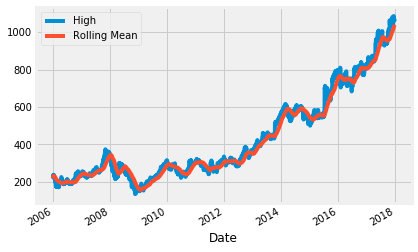

In [73]:
# 滑动窗口
rolling_google = google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
# 使用Google股票的原始High属性绘制90天窗口的滚动平均值
plt.show()

现在可以观察到经过滑动窗口的图比原始数据更平滑一些。

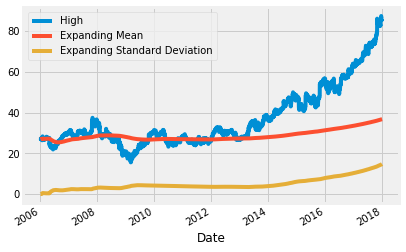

In [74]:
# 扩大窗口函数
microsoft_mean = microsoft.High.expanding().mean()
microsoft_std = microsoft.High.expanding().std()
microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

## [OHLC表](#content)
OHLC图表是显示特定时间段的开盘价，最高价，最低价和收盘价的任何类型的价格图。 开-高-低-闭图表（或OHLC图表）用作交易工具，以可视化并分析证券，货币，股票，债券，商品等随时间的价格变化。OHLC图表对于解释当日价格- 当今市场的情绪，并通过产生的模式预测未来的价格变化。

OHLC图表上的y轴用于价格标度，而x轴是时间标度。 在每个单个时间段上，OHLC图表都会绘制一个代表两个范围的符号：最高和最低交易价格，以及该单个时间段（例如一天）中的开盘价和收盘价。 在范围符号上，高和低价格范围由主垂直线的长度表示。 开盘价和收盘价由刻度线的垂直位置表示，这些刻度线出现在高低垂直线的左侧（代表开盘价）和右侧（代表收盘价）。

可以为每个OHLC图表符号分配颜色，以区分市场是“看涨”（收盘价高于开市价）还是“看迭”（收盘价低于开市价）。

![ohlc](./img/OHLC_chart.svg)

In [84]:
# 2008年的OHLC表
trac = go.Ohlc
trace = go.Ohlc(x=google['06-2008'].index,
                open=google['06-2008'].Open,
                high=google['06-2008'].High,
                low=google['06-2008'].Low,
                close=google['06-2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [85]:
# 2008年的OHLC图
trace = go.Ohlc(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [86]:
# 每年的股市行情
trace = go.Ohlc(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_ohlc')

## [Candlestick charts](#content)
这种图表用作交易工具，以可视化和分析证券，衍生工具，货币，股票，债券，商品等随时间的价格变动。尽管烛台图中使用的符号类似于箱形图，但它们的功能不同, 因此，不要彼此混淆。

烛台图通过使用类似烛台的符号来显示价格信息的多个位，例如开盘价，收盘价，最高价和最低价。 每个符号代表单个时间段（分钟，小时，天，月等）的压缩交易活动。 每个烛台符号均沿时间轴绘制在x轴上，以显示一段时间内的交易活动。

符号中的主要矩形称为真实主体，用于显示该时间段的开盘价和收盘价之间的范围。 从实体的底部和顶部延伸的线被称为上下阴影（或灯芯）。 每个阴影代表所表示的时间段内交易的最高或最低价格。 当市场看涨（收盘价高于开盘价）时，主体通常为白色或绿色。 但是，当市场看跌（收盘价低于开盘价）时，通常将主体涂成黑色或红色。

![candlestick_chart](./img/candlestick_chart.svg)

烛台图表非常适合用来检测和预测一段时间内的市场趋势，并且可以通过每个烛台符号的颜色和形状来解释市场的日常情绪。 例如，身体越长，销售或购买压力就越大。 虽然这是一个非常短的主体，但这表明该时间段内价格变动很小，代表着合并。

烛台图表通过各种指标（例如形状和颜色）以及烛台图表中可以找到的许多可识别模式，帮助揭示市场心理（买卖双方所经历的恐惧和贪婪）。 总共有42种公认的模式，分为简单模式和复杂模式。 烛台图表中的这些模式对于显示价格关系很有用，并可用于预测市场的未来走势。 您可以在此处找到每个模式的列表和描述。

请记住，烛台图不表示开盘价和收盘价之间发生的事件，而仅表示两个价格之间的关系。 因此，您无法确定在那个时间段内交易的波动性。

In [88]:
trace = go.Candlestick(x=google['03-2008'].index,
                open=google['03-2008'].Open,
                high=google['03-2008'].High,
                low=google['03-2008'].Low,
                close=google['03-2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

In [89]:
trace = go.Candlestick(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

In [90]:
trace = go.Candlestick(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_candlestick')

## [自相关和部分自相关](#content)
- 自相关-自相关函数（ACF）可测量序列在不同滞后如何与其自身相关。（用于评估时间序列数据是否依赖于其过去的数据）

- 部分自相关-部分自相关函数可以解释为序列相对于其过去滞后的回归。可以用与标准线性回归相同的方式来解释这些术语，即在使其他滞后保持不变的同时，特定滞后变化的贡献。

acf(..., lag.max = ..., plot = FALSE)函数会计算h=0,1,2...直到lag.max参数指定值对应的自相关系数。
此外，acf()函数的plot选项默认为TRUE，可以生成自相关图，自相关图会显示各lag值对应的自相关系数，并用蓝色水平虚线表示自相关系数为0的95%置信区间边界线，如果自相关系数在两条虚线以内则表明自相关系数没有统计学意义。

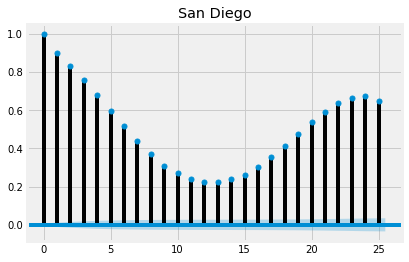

In [91]:
# 圣地亚哥湿度的自相关
plot_acf(humidity["San Diego"],lags=25,title="San Diego")
plt.show()

由于所有滞后都接近于1或至少大于置信区间，因此它们是具有统计学意义的。

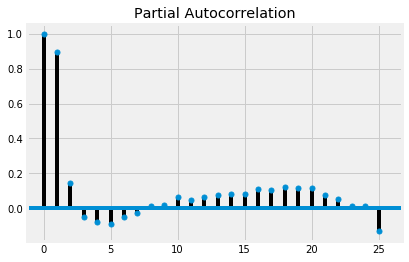

In [92]:
# 圣地亚哥的湿度的部分自相关
plot_pacf(humidity["San Diego"],lags=25)
plt.show()

尽管具有统计学意义，但前两个lags之后的部分自相关非常低。

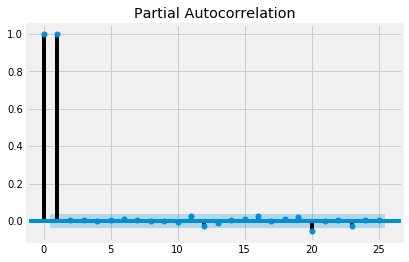

In [93]:
# 微软股票收盘价的部分自相关
plot_pacf(microsoft["Close"],lags=25)
plt.show()

在此，只有第0，第1和第20个滞后在统计上是有意义的。

# [时间序列分解和随机游走](#content)
## [趋势，季节性和噪音](#content)
这些是时间序列的组成部分

- 趋势-时间序列的向上或向下一致的斜率

- 季节性-时间序列的清晰周期性模式（例如正弦函数）

- 噪声-离群值或缺失值

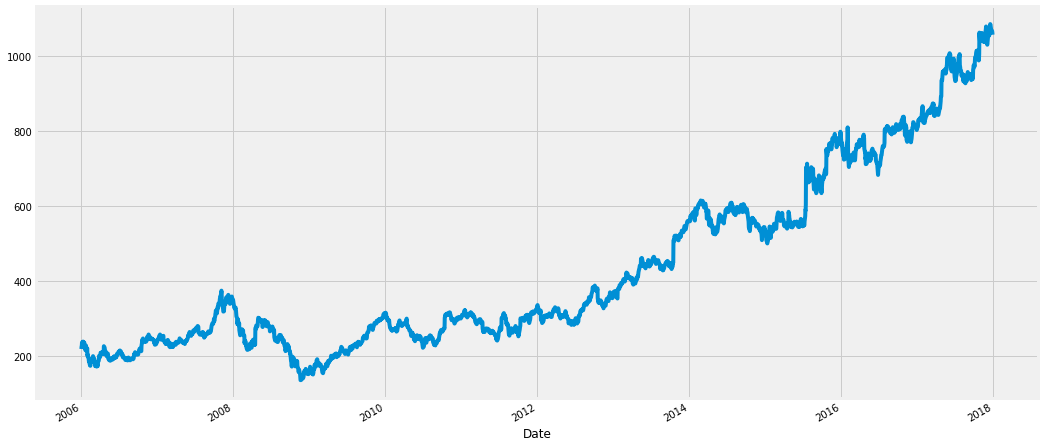

In [95]:
google["High"].plot(figsize=(16,8))

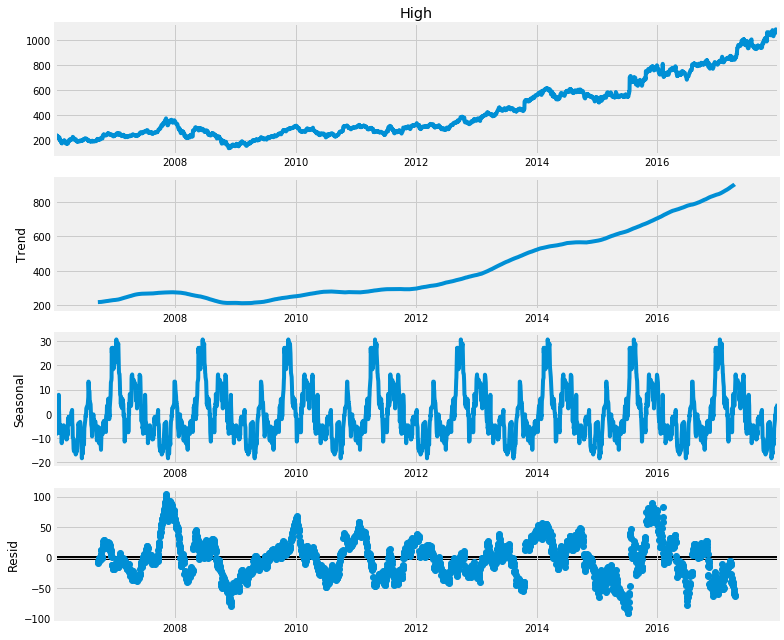

In [96]:
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"],freq=360) # 频率为一年
figure = decomposed_google_volume.plot()
plt.show()

- 上面的图中显然有上升的趋势。

- 您还可以看到统一的季节性变化。

- Non-uniform异常值和缺失值的非均匀噪声

## [白噪声](#content)
白噪声有...

- 恒定均值

- 恒定方差

- 所有滞后的自相关均为零

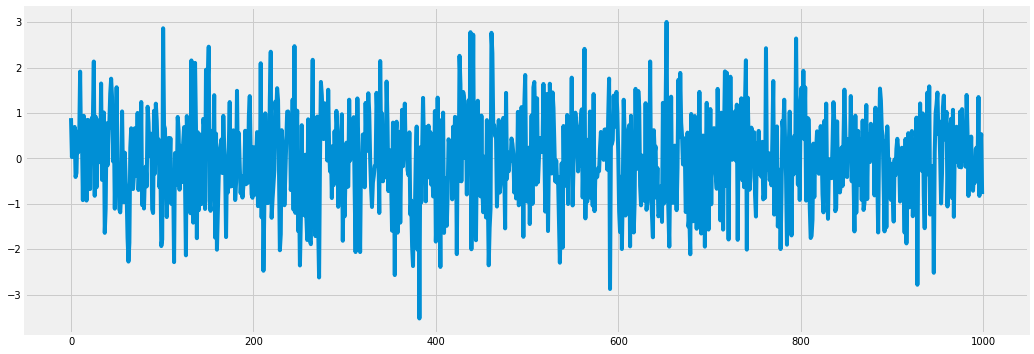

In [97]:
# 显示白噪声
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc是均值，scale是方差
plt.plot(white_noise)

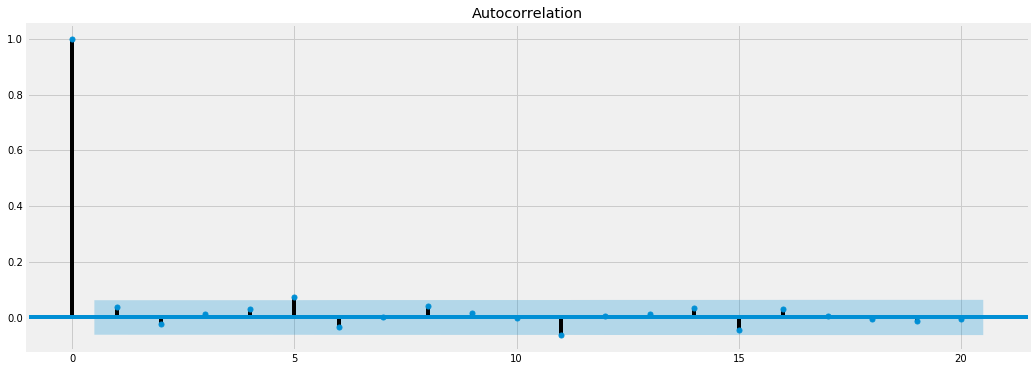

In [98]:
# 绘制白噪声的自相关
plot_acf(white_noise,lags=20)
plt.show()

所有滞后是不具有统计学意义的，因为他们都处在置信区间内。

## [随机游走](#content)
随机游走是一种数学对象，称为随机或随机过程，它描述的路径由某些数学空间（例如整数）上的一系列随机步长组成。

一般来说，如果我们谈论库存，那么今天的价格=昨天的价格+噪音

$P_t = P_{t-1}+\varepsilon_t$

由于噪声是随机的，因此无法预测随机游走。

有漂移的随机游走（漂移μ为零均值）

$P_t - P_{t-1} =\mu + \varepsilon_t$

随机游走的回归测试

$P_t = \alpha + \beta P_{t-1} + \varepsilon_t$

等价于$P_t - P_{t-1} = \alpha + \beta P_{t-1}+\varepsilon_t$

测试：

$H_0 : \beta = 1(是随机游走)$

$H_1 : \beta < 1(不是随机游走)$

迪基·富勒测试：

$H_0 : \beta = 0(是随机游走)$

$H_1 : \beta < 0(不是随机游走)$


增强Dickey-Fuller测试

增强的Dickey-Fuller检验（ADF）检验了时间序列样本中存在单位根的零假设。 基本上，这是Dickey-Fuller测试，RHS上的变化更滞后。

In [99]:
# 谷歌和微软股票交易量的增强Dickey-Fuller测试
adf = adfuller(microsoft["Volume"])
print("p-value of microsoft: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of microsoft: 0.000320152527765203
p-value of google: 6.510719605768194e-07


> 由于Microsoft的p值0.0003201525小于0.05，因此拒绝了原假设，这不是随机游走。
  现在google的p值0.0000006510大于0.05，原假设被拒绝，这不是随机游动。

产生随机游走

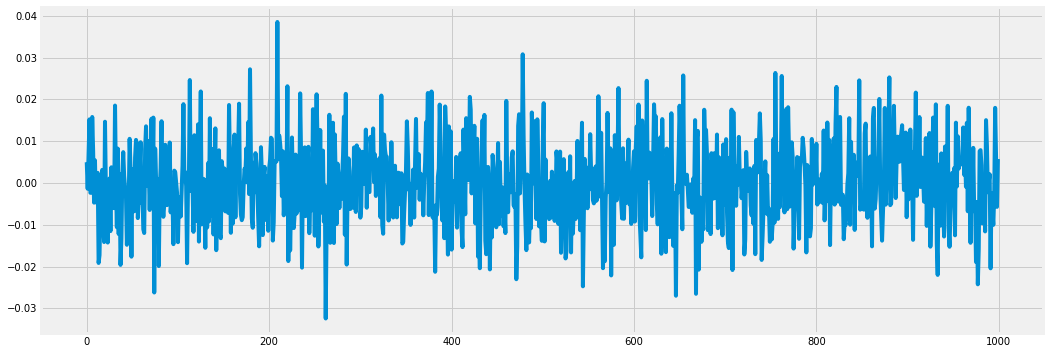

In [100]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

In [101]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
iplot(fig, filename='Basic Distplot')

## [平稳性](#content)
一个稳定的时间序列是一种统计时间特性，例如均值，方差，自相关等随时间变化都是恒定的。

- 平稳性强：是一个随机过程，随着时间的推移，其无条件联合概率分布不会改变。 因此，诸如均值和方差之类的参数也不会随时间变化。

- 平稳性弱：在整个过程中，均值，方差，自相关始终变化的

平稳性很重要，因为依赖时间的非平稳序列具有太多的参数，无法在对时间序列建模时考虑到。 diff()方法可以轻松地将非平稳序列转换为平稳序列。

我们将尝试分解上述分解后的时间序列中的季节性部分。

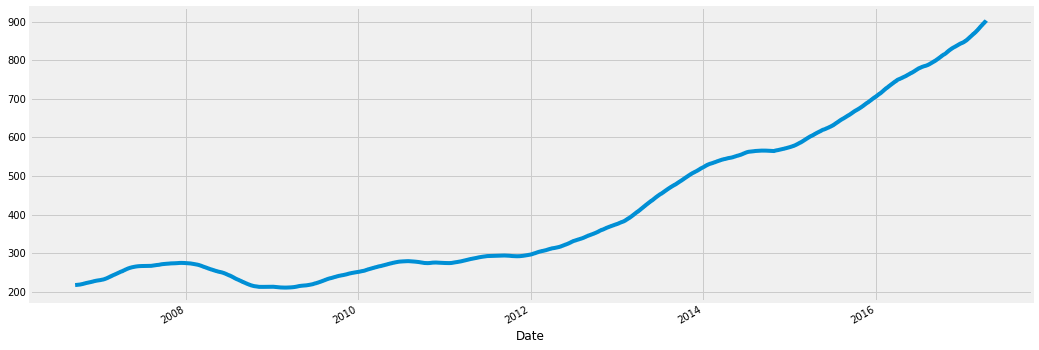

In [102]:
# 显示原始非平稳数据
decomposed_google_volume.trend.plot()

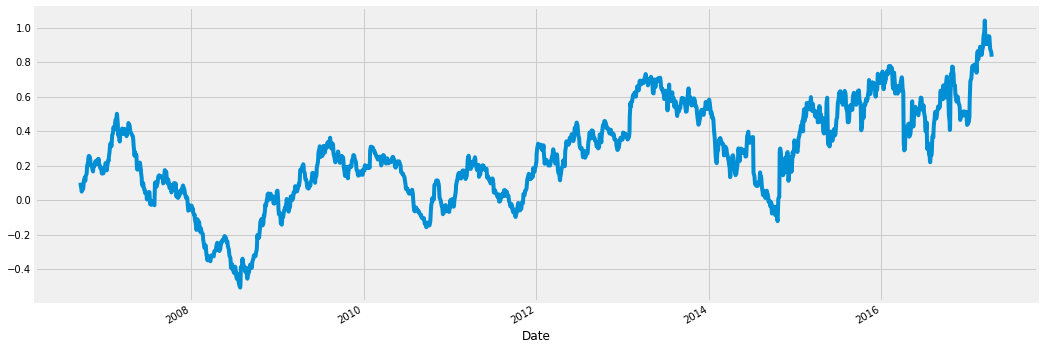

In [103]:
# 新的平稳的图像
decomposed_google_volume.trend.diff().plot()

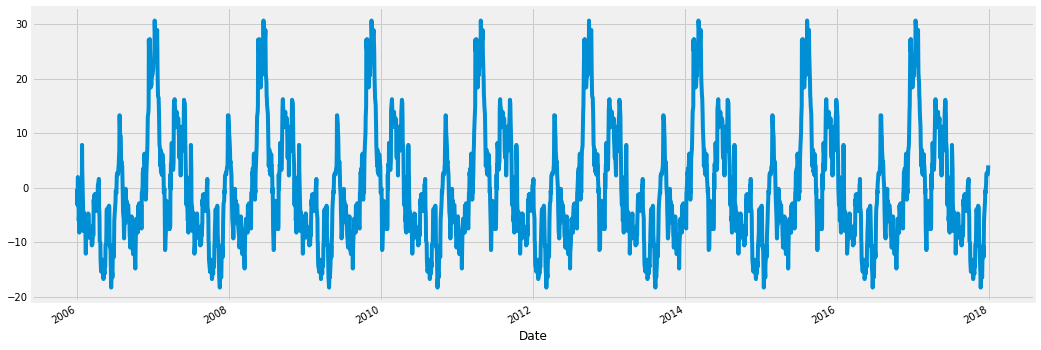

In [105]:
decomposed_google_volume.seasonal.plot()

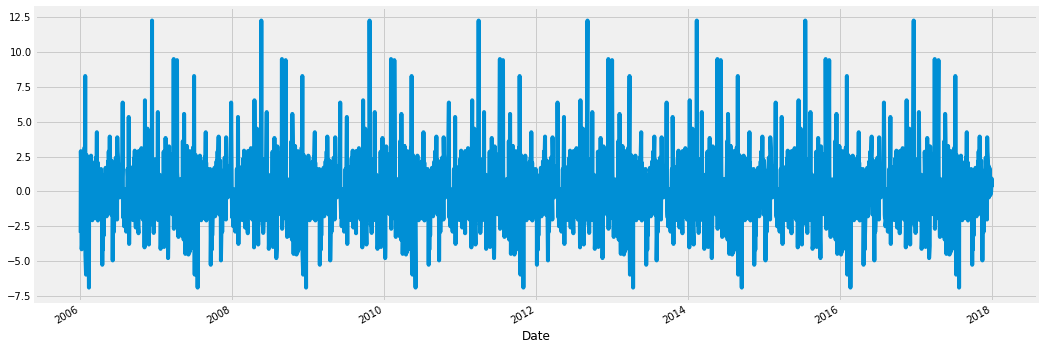

In [106]:
decomposed_google_volume.seasonal.diff().plot()

# [建模](#content)
## [AR模型](#content)
自回归（AR）模型是一种随机过程的表示； 因此，自回归模型指定输出变量线性地取决于其自身的先前值和随机项（一个不完全可预测的项）； 因此该模型采用随机差分方程的形式。

AR(1) model

$Rt = μ + ϕRt-1 + εt$

As RHS has only one lagged value(Rt-1)this is called AR model of order 1 where μ is mean and ε is noise at time t

If $ϕ = 1$, it is random walk. Else if $ϕ = 0$, it is white noise. Else if $-1 < ϕ < 1$, it is stationary. If $ϕ$ is -ve, there is men reversion. If $ϕ$ is +ve, there is momentum.

AR(2) model

$Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + εt$

AR(3) model

$Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + ϕ3Rt-3 + εt$

模拟AR(1)模型

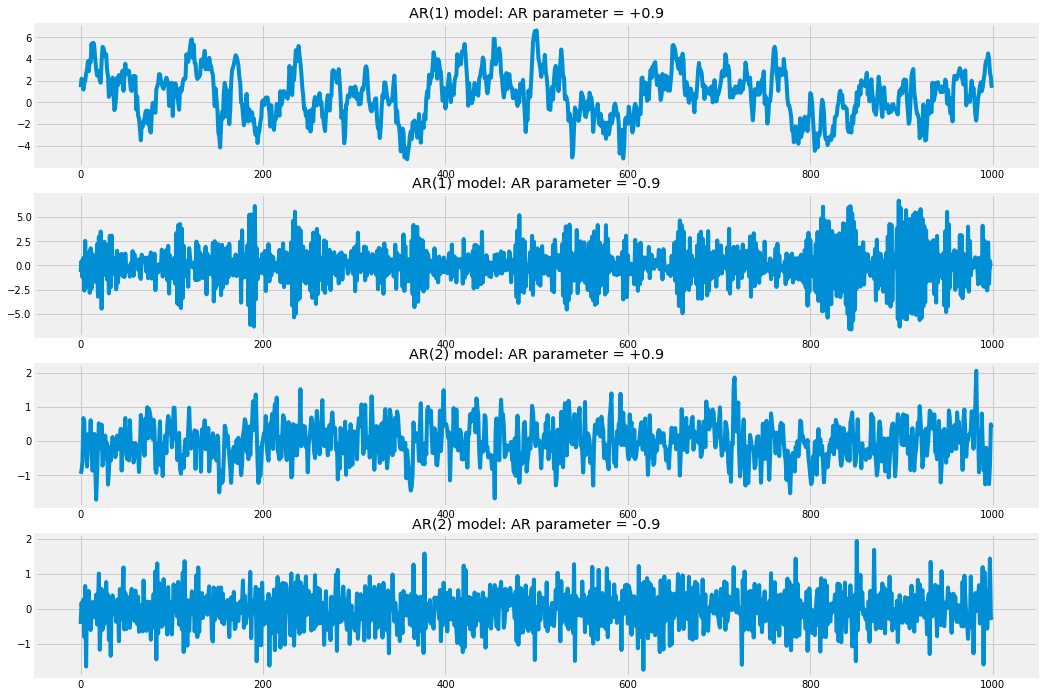

In [107]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

预测模拟模型

In [108]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Tue, 21 Jul 2020   AIC                           2837.403
Time:                        14:58:04   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

ϕ约为0.9，这是我们在第一个模拟模型中选择的AR参数。

预测模型

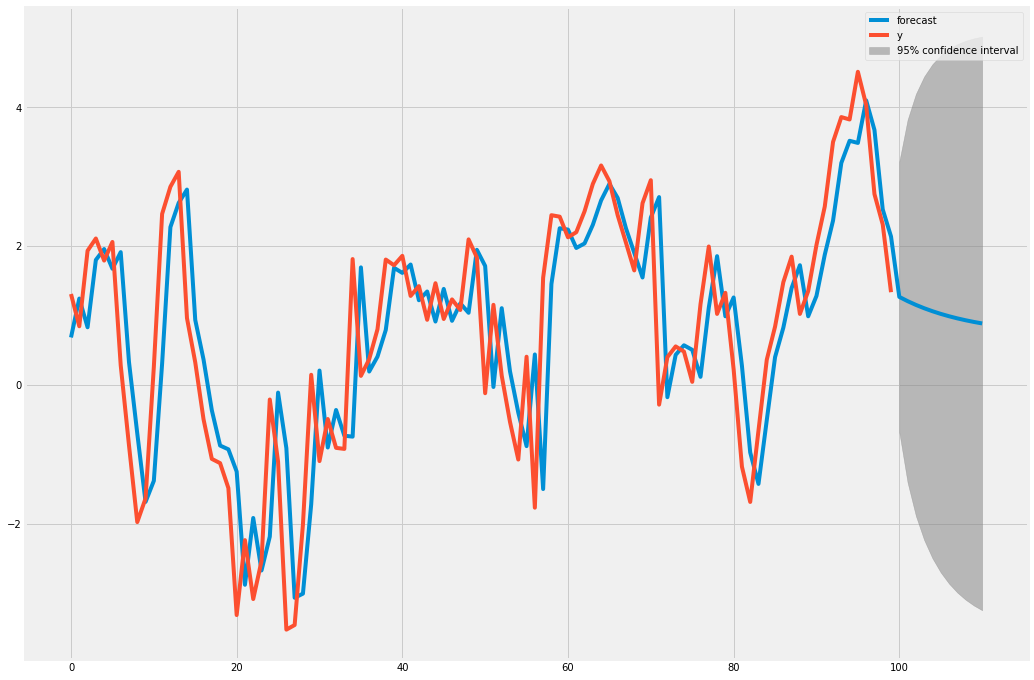

In [109]:
result.plot_predict(start=900, end=1010)
plt.show()

In [110]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054526369481.


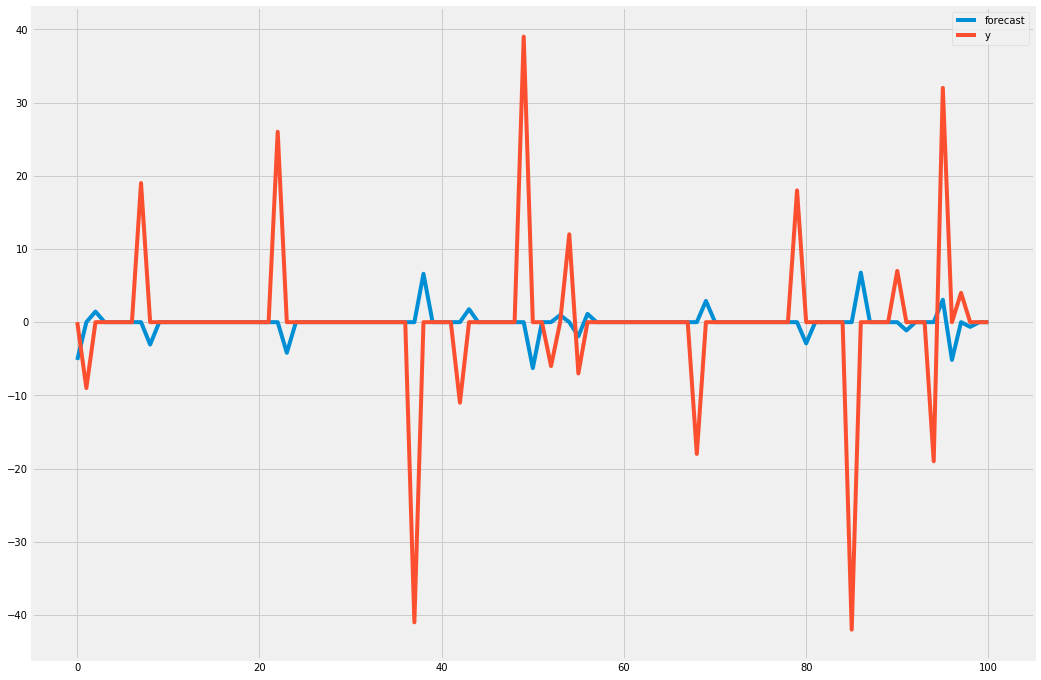

In [111]:
# 预测蒙特利尔的湿度
humid = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=1000, end=1100)
plt.show()

In [112]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7.218388564742593.


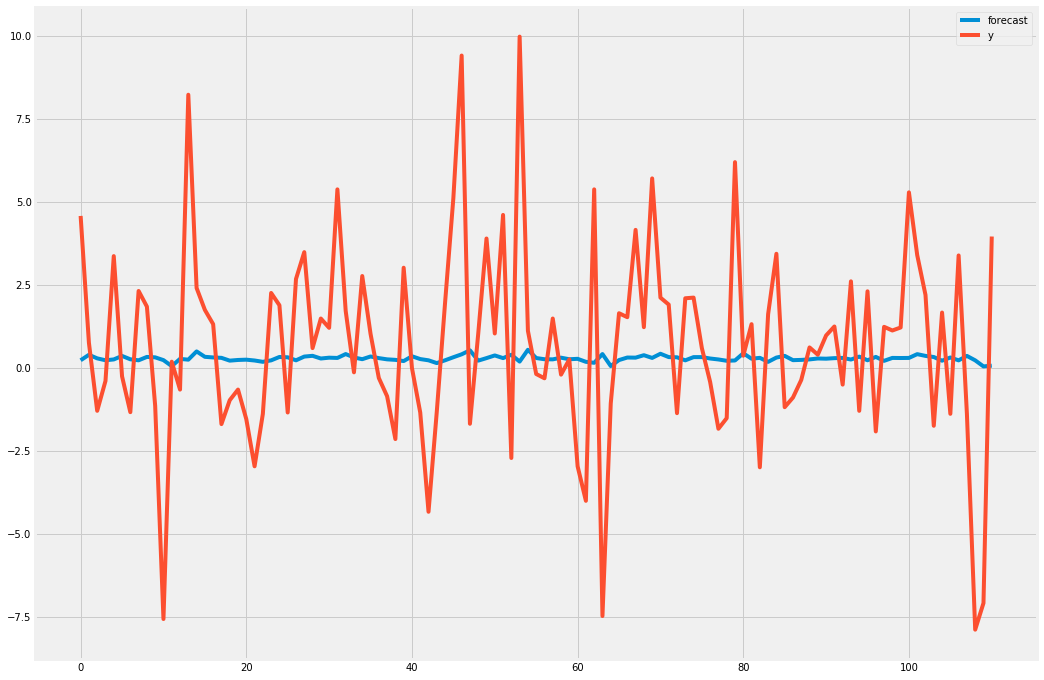

In [113]:
humid = ARMA(google["Close"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=900, end=1010)
plt.show()

## [MA模型](#content)
移动平均（MA）模型是建模单变量时间序列的常用方法。 移动平均模型指定输出变量线性地取决于随机（不完全可预测）项的当前值和各种过去值。

MA(1) model

$Rt = μ + ϵ_t1 + θ_ϵ{t-1}$

转换为今天的收益=平均值+今天的噪音+昨天的噪音

由于RHS中只有1个滞后值，因此它是1阶的MA模型

模拟MA(1)模型

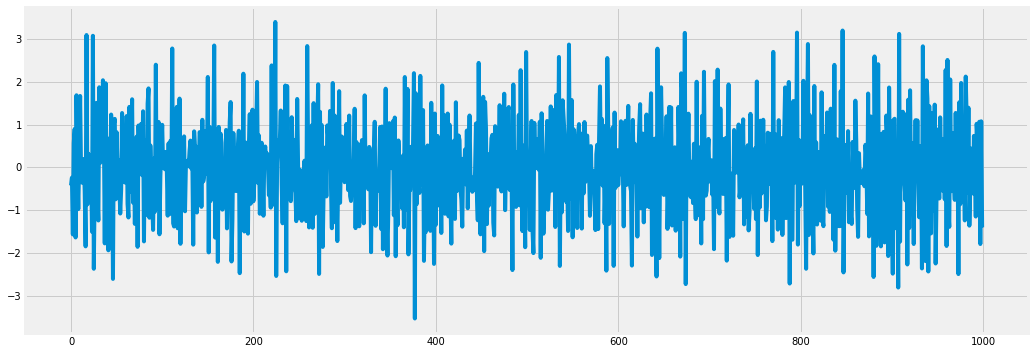

In [114]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

预测模型MA模型

In [115]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Tue, 21 Jul 2020   AIC                           2852.553
Time:                        15:05:53   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots           

使用MA模型预测

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                45251
Model:                     ARMA(0, 3)   Log Likelihood             -153516.982
Method:                       css-mle   S.D. of innovations              7.197
Date:                Tue, 21 Jul 2020   AIC                         307043.965
Time:                        15:06:54   BIC                         307087.564
Sample:                             0   HQIC                        307057.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.031     -0.025      0.980      -0.061       0.060
ma.L1.y       -0.1621      0.005    -34.507      0.000      -0.171      -0.153
ma.L2.y        0.0386      0.005      8.316      0.0

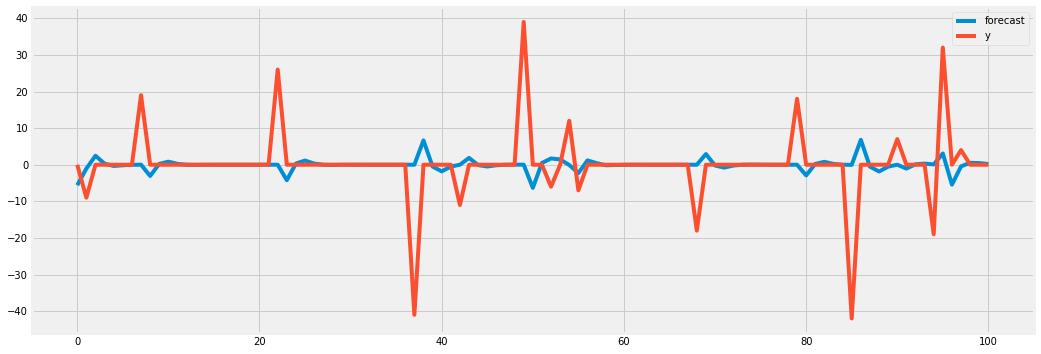

In [116]:
# 预测湿度
model = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [117]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 11.345130546173813.


## [ARMA模型](#content)
自回归移动平均（ARMA）模型以两个多项式来简要描述（弱）平稳随机过程，一个多项式用于自回归，第二个用于移动平均值。 这是AR和MA模型的融合。

ARMA(1,1)模型

$Rt =μ+ ϕRt-1 + ϵt + θϵt-1$

基本上，今天的收益=平均值+昨天的收益+噪音+昨天的噪音。

使用ARMA模型进行预测

我没有模拟任何模型，因为它与AR和MA模型非常相似。 只是对这一情况进行预测。

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -55408.974
Method:                       css-mle   S.D. of innovations       22751608.043
Date:                Tue, 21 Jul 2020   AIC                         110833.948
Time:                        15:09:19   BIC                         110882.047
Sample:                             0   HQIC                        110851.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   9915.500     -2.047      0.041   -3.97e+04    -863.198
ar.L1.y        0.2053      0.160      1.286      0.198      -0.107       0.518
ar.L2.y        0.7296      0.179      4.078      0.0

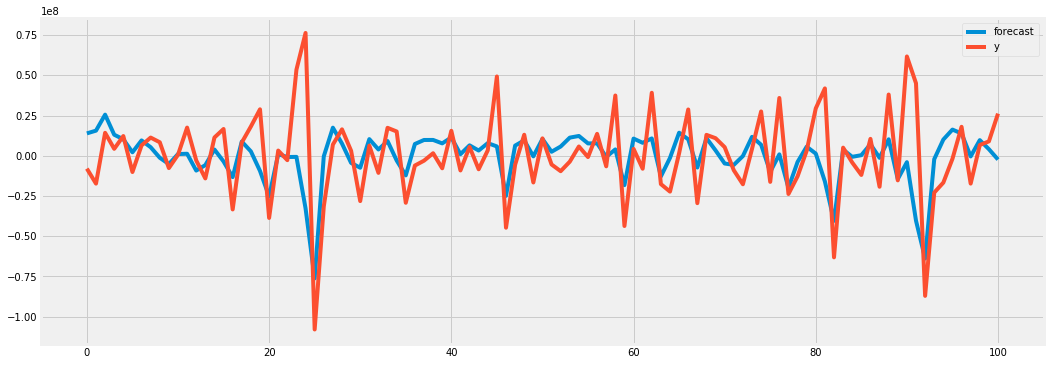

In [118]:
# 预测股票
model = ARMA(microsoft["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [119]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38038312.01046139.


ARMA模型要比AR和MA模型好得多

## [ARIMA模型](#content)
自回归综合移动平均值（ARIMA）模型是自回归移动平均值（ARMA）模型的概括。 这两个模型都适合于时间序列数据，以更好地理解数据或预测序列中的未来点（预测）。 ARIMA模型适用于数据显示非平稳性的某些情况，其中可以执行一次或多次初始差分步骤（对应于模型的“集成”部分）以消除非平稳性。 ARIMA模型的形式为：ARIMA(p，d，q)：p是AR参数，d是微分参数，q是MA参数

ARIMA1,0,0)

$yt = a1yt-1 + ϵt$

ARIMA(1,0,1)

$yt = a1yt-1 + ϵt + b1ϵt-1$

ARIMA(1,1,1)

$Δyt=a1Δyt-1+ ϵt + b1ϵt-1$ 其中$Δyt= yt-yt-1$

使用ARIMA模型进行预测

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -56385.467
Method:                       css-mle   S.D. of innovations       31647215.008
Date:                Tue, 21 Jul 2020   AIC                         112778.933
Time:                        15:13:27   BIC                         112802.981
Sample:                             1   HQIC                        112787.581
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9984.0302   2.48e+05      0.040      0.968   -4.75e+05    4.95e+05
ar.L1.D.y     -0.8716      0.016    -53.758      0.000      -0.903      -0.840
ar.L2.D.y     -0.4551      0.016    -28.071      0.0

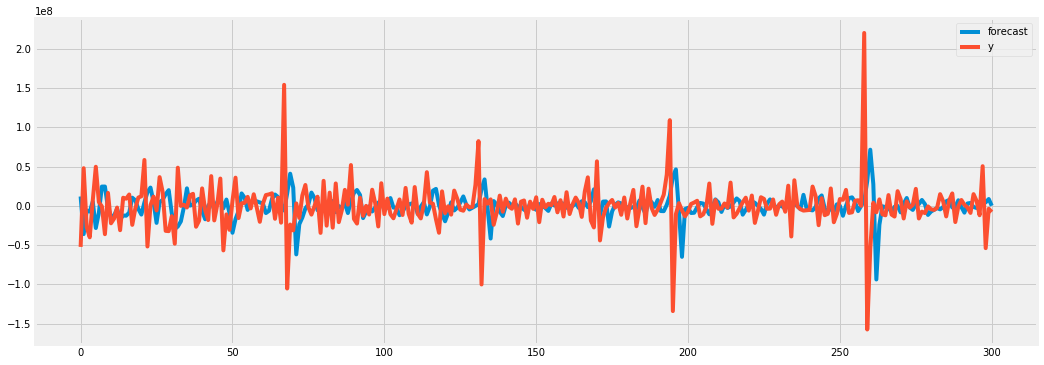

In [121]:
rcParams['figure.figsize'] = 16, 6
model = ARIMA(microsoft["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [122]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 61937615.12826711.


## [VAR模型](#content)
向量自回归（VAR）是一种随机过程模型，用于捕获多个时间序列之间的线性相互依赖性。 VAR模型通过允许多个演化变量来概括单变量自回归模型（AR模型）。 VAR中的所有变量都以相同的方式进入模型：每个变量都有一个方程式，该方程式根据其自身的滞后值，其他模型变量的滞后值和误差项来解释其演化。 VAR建模不需要像具有联立方程的结构模型那样了解有关影响变量的知识：唯一需要的先验知识是可以假设会在跨时间相互影响的变量列表。

                           Statespace Model Results                           
Dep. Variable:     ['Close', 'Close']   No. Observations:                 3018
Model:                     VARMA(2,1)   Log Likelihood              -12185.060
                          + intercept   AIC                          24404.120
Date:                Tue, 21 Jul 2020   BIC                          24506.330
Time:                        15:18:30   HQIC                         24440.873
Sample:                             0                                         
                               - 3018                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                77.61, 78.86   Jarque-Bera (JB):   48213.37, 14927.77
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.31, 1.62   Skew:                      1.15, -0.03
Prob(H) (two-sided):            0.00,

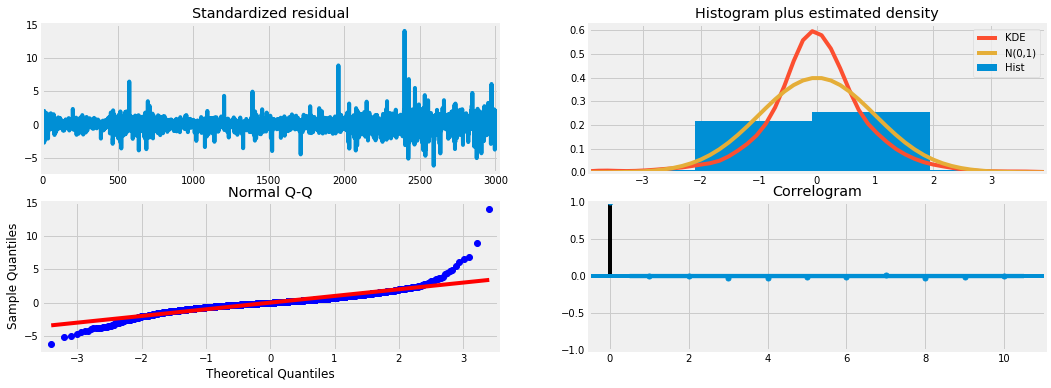

In [123]:
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

## [状态空间方法](#content)
一般状态空间模型的形式为
yt =Ztαt+ dt +εt

αt=Ttαt-1+ ct +Rtηt

其中yt表示时间t的观察向量，αt表示时间t的（未观察到）状态向量，并且 其中不规则分量定义为

εt〜N（0，Ht）

ηt〜N（0，Qt）

等式中的其余变量（Zt，dt，Ht，Tt，ct，Rt，Qt）是描述过程的矩阵。 它们的变量名称和尺寸如下：

Z：设计（k_endog×k_states×nobs）
d：obs_intercept（k_endog×nobs）
H：obs_cov（k_endog×k_endog×nobs）
T：过渡（k_states×k_states×nobs）
c：state_intercept（  k_states×nobs）
R：选择（k_states×k_posdef×nobs）
Q：state_cov（k_posdef×k_posdef×nobs）

在矩阵之一是时间不变的情况下（例如，Zt = Zt + 1∀t  ），它的最后一个尺寸可能是大小1，而不是大小点。

这种通用形式封装了许多最流行的线性时间序列模型（请参见下文），并且非常灵活，允许在缺少观测值，预测，脉冲响应函数等情况下进行估算。

### [SARIMA](#content)
SARIMA模型可用于建模季节时间序列，其中给定季节的平均值和其他统计数据在这些年中都不稳定。 定义的SARIMA模型构成了所提出的非季节性自回归移动平均值（ARMA）模型和自回归综合移动平均值（ARIMA）模型的直接扩展。

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3018
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -10098.322
Date:                Tue, 21 Jul 2020   AIC                          20216.645
Time:                        15:23:06   BIC                          20276.768
Sample:                             0   HQIC                         20238.265
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1016      0.048      2.122      0.034       0.008       0.195
ar.L1          0.2279      0.007     33.965      0.000       0.215       0.241
ar.L2          1.1213      0.006    200.505      0.0

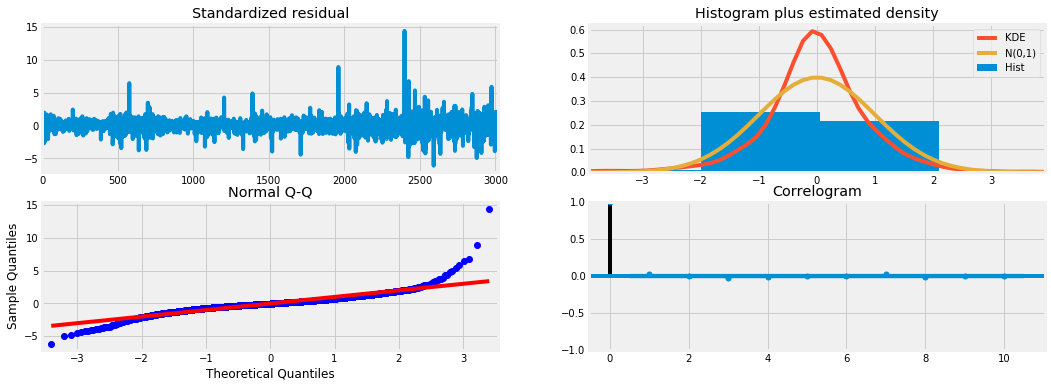

In [124]:
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

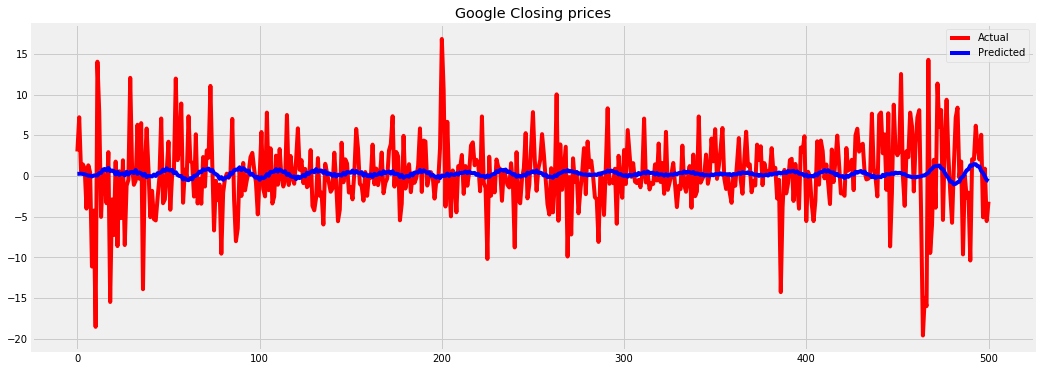

In [125]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

### [不可观察的组件](#content)
UCM将响应序列分解为趋势，季节，周期和因预测变量序列引起的回归效应之类的成分。 以下模型显示了一种可能的情况：

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 3018
Model:                    local level   Log Likelihood              -10116.511
Date:                Tue, 21 Jul 2020   AIC                          20237.023
Time:                        15:25:31   BIC                          20249.047
Sample:                             0   HQIC                         20241.346
                               - 3018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    47.7219      0.384    124.248      0.000      46.969      48.475
sigma2.level      5.033e-05      0.000      0.458      0.647      -0.000       0.000
Ljung-Box (Q):              

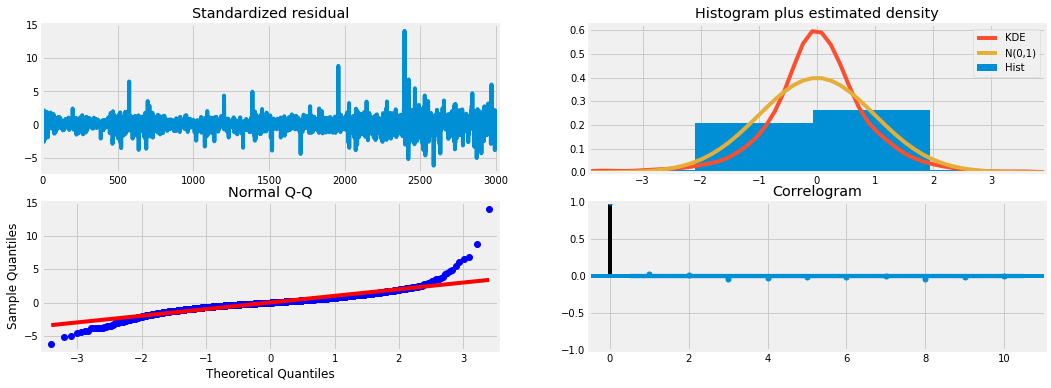

In [126]:
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

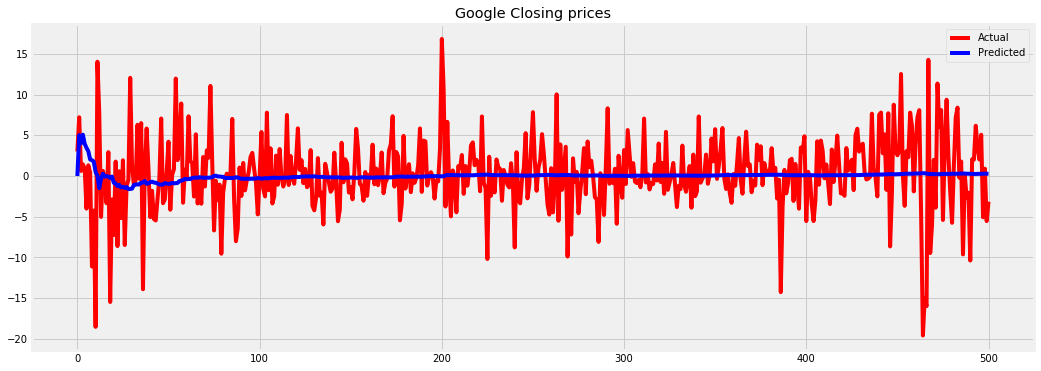

In [127]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

### [动态因子模型](#content)
动态因子模型是用于多元时间序列的灵活模型，其中观察到的内生变量是外生协变量和未观察因子的线性函数，它们具有向量自回归结构。 未观察到的因素也可能是外源协变量的函数。 因变量方程中的扰动可能是自相关的。

                                   Statespace Model Results                                  
Dep. Variable:                    ['Close', 'Close']   No. Observations:                 3018
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood              -12667.898
Date:                               Tue, 21 Jul 2020   AIC                          25347.796
Time:                                       15:26:42   BIC                          25383.870
Sample:                                            0   HQIC                         25360.767
                                              - 3018                                         
Covariance Type:                                 opg                                         
Ljung-Box (Q):                82.50, 75.00   Jarque-Bera (JB):   48871.09, 15298.36
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.36, 1.82   Skew:                       1.11, 0

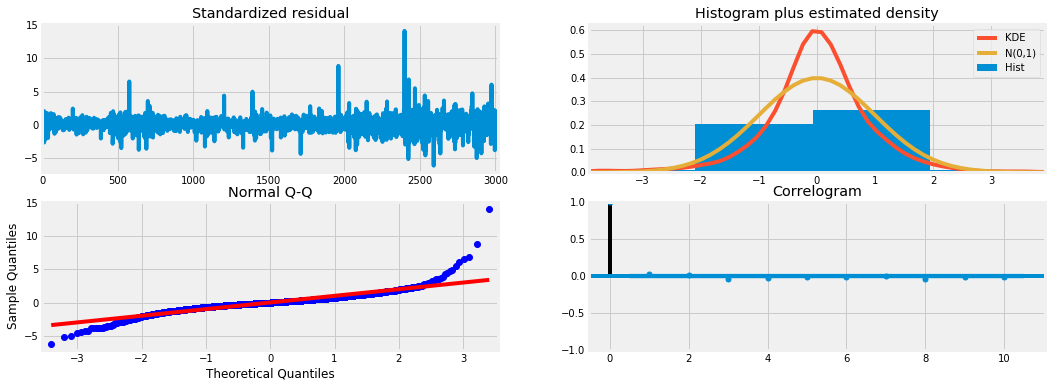

In [128]:
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))